In [255]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from cdo import *
from pathlib import Path
from os import path, remove
import sys
from cftime import Datetime360Day
cdo = Cdo()
import geopandas as gpd

In [2]:
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *

In [24]:
data_dir = Path("/home/abhi/Documents/data")
fpaths = {}
fpaths['obs'] = data_dir.joinpath("OBSERVATION/IMD/precip/1971-2000_rm_ll25_360day.nc")
fpaths['rcm'] = data_dir.joinpath("PRECIS/base/precip/1971-2000_rm_ll25.nc")
fpaths['gcm'] = Path("/home/abhi/Documents/mygit/GCM_RCM/data/HADGEM2-ES/precip/daymean/pr_day_HadGEM2-ES_historical_r1i1p1_19710101-20001230.nc")

In [256]:
shp = (gpd
       .read_file('/home/abhi/Documents/data/shapefiles/India_climatic_correct/India_climatic_correct.shp'))

shp = shp.loc[~shp.Region.str.startswith('Him'), :]

### NPPI Onset and Retreat 

In [15]:
def calc_nppi(f):
    P = cdo.ydaymean(input=f"-timselmean,5 {f}",
                    returnCDF=True)
    res = cdo.setvar('nppi',
                     input=f"-div -sub {P} -timmin {P} -sub -timmax {P} -timmin {P}",
                  returnCDF=True)
    os.system(f"rm {P}")
    
    return res

In [16]:
def getMOdate(cell, ti):
    '''
    Returns the pentad of the monsoon onset
    when the NPPI exceeds 0.618 for the first
    time.
    @params:
        cell: time series for a grid point
        ti: pentad time index
    '''
    try:
        index = np.array(np.where(cell > 0.618)[0][0])
        return ti[index]
    except Exception:
        return np.nan

def getMRdate(cell, ti):
    '''
    Returns the pentad of the monsoon retreat
    when the NPPI falls below 0.618 for the last
    time.
    @params:
        cell: time series for a grid point    
        ti: pentad time index
    '''
    try:
        index = np.array(np.where(cell > 0.618)[0][-1])
        return ti[index]
    except Exception:
        return np.nan

In [25]:
%%time
nppi_dsets = []
for f in ['obs', 'rcm', 'gcm']:
    nppi_dsets.append(xr.open_dataset(calc_nppi(fpaths[f])))

CPU times: user 108 ms, sys: 40 ms, total: 148 ms
Wall time: 11 s


In [30]:
nppi_dsets[1] = nppi_dsets[1].rename({'t': 'time'})

In [37]:
nppi_dsets[0]['time'] = nppi_dsets[1]['time']

In [91]:
modelIndex = pd.Index(['IMD', 'PRECIS', 'HADGEM2-ES'], name='model')

In [92]:
nppi_ds = xr.concat(nppi_dsets, dim=modelIndex)

In [93]:
nppi_ds.coords

Coordinates:
  * time     (time) object 2000-01-03 12:00:00 ... 2000-12-28 12:00:00
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * model    (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'

In [85]:
modelIndex.values

array(['IMD', 'HADGEM2-ES', 'PRECIS'], dtype=object)

In [232]:
# Extract required lat, lon, ti, and dims to create a DataArray
lat = nppi_ds.coords['lat'].copy()
lon = nppi_ds.coords['lon'].copy()
ti = nppi_ds.indexes['time']
dims = {'model': np.array(['IMD', 'PRECIS', 'HADGEM2-ES'], dtype=str),
        'lat': lat,
        'lon': lon}

In [45]:
np.apply_along_axis(getMOdate, ti=ti, axis=0, arr=nppi_ds.nppi.values)

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [75]:
ti_dayofyr = pd.Series(ti).apply(lambda x: x.dayofyr)

In [213]:
%%time
# Onset DataArray
O_da = xr.DataArray(np.apply_along_axis(getMOdate, ti=ti_pentad, axis=1, arr=nppi_ds.nppi.values),
                      dims=dims,
                      name='Onset')

# Retreat DataArray
R_da = xr.DataArray(np.apply_along_axis(getMRdate, ti=ti_pentad, axis=1, arr=nppi_ds.nppi.values),
                      dims=dims,
                      name='Retreat')

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


In [215]:
Mdates = O_da.to_dataset().assign(Retreat=R_da)

In [216]:
modelIndex

Index(['IMD', 'PRECIS', 'HADGEM2-ES'], dtype='object', name='model')

In [217]:
Mdates['model'] = modelIndex

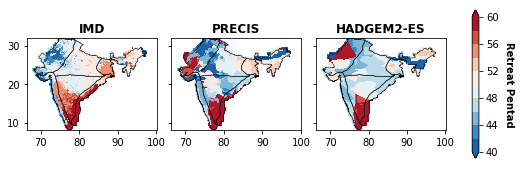

In [306]:
g = Mdates.Retreat.plot(col='model', levels=np.arange(40, 60.1, 2), cmap='RdBu_r')

g.cbar.remove()
for ax in g.fig.axes:
    title = ax.get_title().replace('model = ', '')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    shp.boundary.plot(edgecolor='black', ax=ax, linewidth=0.5)
    ax.set_ylim(8, 32)
    
g.add_colorbar()

g.cbar.set_label('Retreat Pentad', rotation=270, labelpad=15, fontweight='bold')

outdir = '../plots/compare/precip/Onset-Retreat-NPPI/'
os.system(f'mkdir -p {outdir}')
g.fig.savefig(f'{outdir}/IMD_PRECIS_HADGEM2-ES_Retreat_Pentad.png', dpi=400,
             bbox_inches='tight')

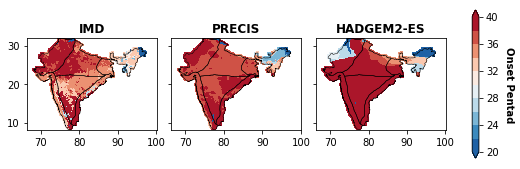

In [307]:
g = Mdates.Onset.plot(col='model', cmap='RdBu_r',
                 levels=np.arange(20, 40.1, 2))
g.cbar.remove()
for ax in g.fig.axes:
    title = ax.get_title().replace('model = ', '')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    shp.boundary.plot(edgecolor='black', ax=ax, linewidth=0.5)
    ax.set_ylim(8, 32)
    
g.add_colorbar()

g.cbar.set_label('Onset Pentad', rotation=270, labelpad=15, fontweight='bold')
outdir = '../plots/compare/precip/Onset-Retreat-NPPI/'
os.system(f'mkdir -p {outdir}')
g.fig.savefig(f'{outdir}/IMD_PRECIS_HADGEM2-ES_Onset_Pentad.png', dpi=400,
             bbox_inches='tight')

In [301]:
ax.set_ylim(8, 32)

(8, 32)

In [296]:
g.cbar.set_ticklabels()

array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])

In [234]:
Mdates.coords['lon'] = lon
Mdates.coords['lat'] = lat

In [235]:
Mdates.coords

Coordinates:
  * model    (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5

In [236]:
hadgem_od = Mdates.Onset.sel(model='HADGEM2-ES')

In [242]:
hadgem_od.loc[dict(lon=lon[(lon>=77)&(lon<=80)],
                  lat=lat[(lat>=12)&(lat<=17)])] = selhad

In [238]:
selhad

<xarray.DataArray 'Onset' (lat: 21, lon: 13)>
array([[55., 55., 55., ..., 58., 58., nan],
       [55., 55., 55., ..., 58., 58., nan],
       [55., 55., 55., ..., 58., 58., 58.],
       ...,
       [ 3., 42., 42., ..., 41., 41., 41.],
       [41., 41., 41., ..., 41., 41., 41.],
       [41., 41., 41., ..., 41., 41., 41.]])
Coordinates:
    model    <U10 'HADGEM2-ES'
  * lon      (lon) float64 77.0 77.25 77.5 77.75 78.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float64 12.0 12.25 12.5 12.75 13.0 ... 16.25 16.5 16.75 17.0

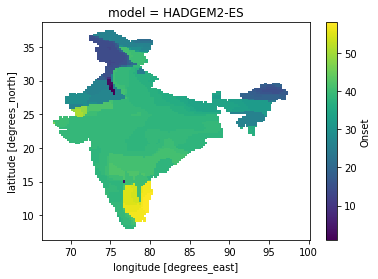

In [211]:
hadgem_od.plot()

In [200]:
arr = selhad.values

In [239]:
arr[arr < 30] = 40

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [240]:
selhad.values = arr

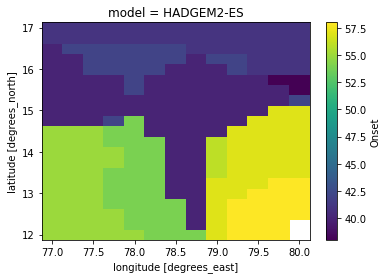

In [241]:
selhad.plot()

### Calculate onset and retreat on original grid ==> interpolate and mask